<a href="https://colab.research.google.com/github/wesleybeckner/technology_fundamentals/blob/main/C4%20Machine%20Learning%20II/SOLUTIONS/SOLUTION_Tech_Fun_C4_S1_Computer_Vision_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technology Fundamentals Course 4, Session 1: Computer Vision Part 1

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

**Teaching Assitants**: Varsha Bang, Harsha Vardhan

**Contact**: vbang@uw.edu, harshav@uw.edu
<br>

---

<br>

In this session we will turn our magnifying glass over to images. There are many application-centric subdomains of machine learning and this is one of them (another would be natural language processing). We can use the power of image related machine learning to replace, augment, or optimize what would typically be reserved for a humans. 

In this session we will:

* Use modern deep-learning networks using keras
* Design CNNs
* Learn about feature extraction in convolutional layers
* Learn about transfer learning
* Utilize data augmentation in the context of images

<br>

_images in this notebook borrowed from [Ryan Holbrook](https://mathformachines.com/)_

---

<br>

<a name='top'></a>

# Contents

* 3.0 [Preparing Environment and Importing Data](#x.0)
  * 3.0.1 [Import Packages](#x.0.1)
  * 3.0.2 [Load Dataset + Segway Into Images](#x.0.2)
* 3.1 [The Classifier Structure](#x.1)
* 3.2 [Convolutions, ReLU and Maximum Pooling](#x.2)
  * 3.2.1 [The Convolution](#x.2.1)
  * 3.2.2 [Activations](#x.2.2)
  * 3.2.3 [ReLU](#x.2.3)
  * 3.2.4 [Exercise: Experiment with Kernels](#x.2.4)
  * 3.2.5 [Condense with Maximum Pooling](#x.2.5)
* 3.3 [Enrichment: Practice with Global Average Pooling](#x.3)
  

<br>

---

<a name='x.0'></a>

## 3.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>

### 3.0.1 Import Packages

[back to top](#top)

In [53]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

import numpy as np
from itertools import product

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # helper function borrowed from Ryan Holbrock
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

<a name='x.0.2'></a>

### 3.0.2 Load Dataset + Segway Into Images

[back to top](#top)

We're going to be working with a new kind of data structure today, _an image_. There are [many ways](https://towardsdatascience.com/what-library-can-load-image-in-python-and-what-are-their-difference-d1628c6623ad) to load images into python: _matplotlib (`plt.imread()`), OpenCV (`cv2.imread()`), Pillow (`Image.open()`), scikit-image (`io.imread()`), tensorflow (` tf.io.read_file()` and `tf.io.decode_jpeg()`)_.

Let's give these a shot!

In [54]:
# Sync your google drive folder
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
# image read libraries
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import skimage
from skimage import io

### YOU WILL CHANGE TO THE PATH WHERE YOU HAVE TECH_FUNDAMENTALS ###
path_to_casting_data = '/content/drive/MyDrive/courses/TECH_FUNDAMENTALS/data/casting_data_class_practice'
technocast_train_path = path_to_casting_data + '/train/'
image_path = technocast_train_path + '/ok_front/cast_ok_0_1.jpeg'

<class 'numpy.ndarray'>
(300, 300, 3)


(-0.5, 299.5, 299.5, -0.5)

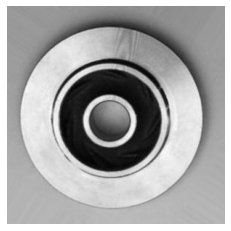

In [56]:
# pyplot
import matplotlib.pyplot as plt
img1 = plt.imread(image_path)
print(type(img1))
print(img1.shape)
plt.imshow(img1)
plt.axis('off')

<class 'numpy.ndarray'>
(300, 300, 3)


(-0.5, 299.5, 299.5, -0.5)

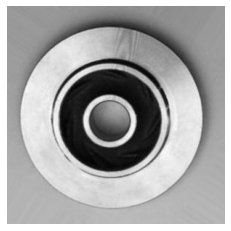

In [57]:
# cv2
import cv2
img2 = cv2.imread(image_path)
print(type(img2))
print(img2.shape)
plt.imshow(img2)
plt.axis('off')

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(300, 300, 3)


(-0.5, 299.5, 299.5, -0.5)

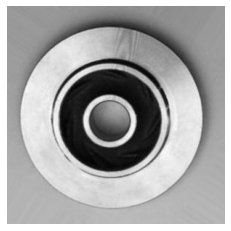

In [58]:
# PIL
from PIL import Image
img3 = Image.open(image_path)
print(type(img3))
print(np.array(img3).shape) #conv to array
plt.imshow(img3)
plt.axis('off')

<class 'numpy.ndarray'>
(300, 300, 3)


(-0.5, 299.5, 299.5, -0.5)

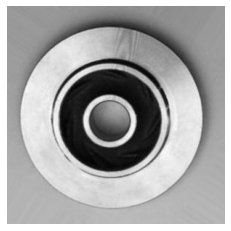

In [59]:
# skimage
import skimage
img4 = skimage.io.imread(image_path)
print(type(img4))
print(img4.shape)
plt.imshow(img4)
plt.axis('off')

<class 'tensorflow.python.framework.ops.EagerTensor'>
(300, 300, 1)
(300, 300)


(-0.5, 299.5, 299.5, -0.5)

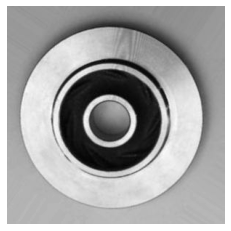

In [60]:
# tensorflow
img5 = tf.io.read_file(image_path)
img5 = tf.io.decode_jpeg(img5)

# conver to bw
img5 = tf.image.rgb_to_grayscale(img5)

# optionally could convert to an array
# img5 = np.asarray(img5)
print(type(img5))
print(img5.shape)

# drop the extra channel (3d squeezed into 2d, rgb to intensity/gray)
print(tf.squeeze(img5).shape)
plt.imshow(tf.squeeze(img5), cmap='gray', vmin=0, vmax=255)
plt.axis('off')

#### 3.0.2.1 Exercise: Loading Images

Find 2 different images on the internet (any 2 of: jpg, png, and svg format). Load them into python as

1. colored, and then also convert to
2. grayscale

using tensorflow and pyplot. Convert to grayscale using `tf.image.rgb_to_grayscale` for one of the images and `np.dot()` for the other.

In [61]:
img_path2 = "/content/drive/MyDrive/courses/TECH_FUNDAMENTALS/data/squirtle.png"

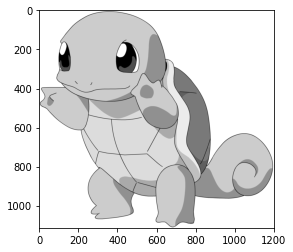

In [62]:
# tensorflow

### YOUR CODE HERE ###
img = tf.io.read_file(img_path2)
img = tf.io.decode_jpeg(img)

# extra channel (alpha channel for opacity, sometimes)
img = tf.image.rgb_to_grayscale(img[:,:,:3])

plt.imshow(tf.squeeze(img), cmap='gray')

In [63]:
img_path3 = "/content/drive/MyDrive/courses/TECH_FUNDAMENTALS/data/ghastly.jpg"

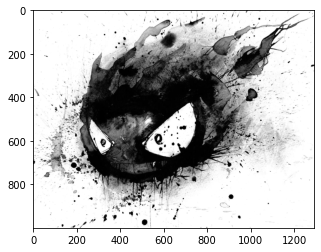

In [64]:
# pyplot

### YOUR CODE HERE ###
img = plt.imread(img_path3)

# extra channel (alpha channel for opacity, sometimes)
rgb_weights = [1/3, 1/3, 1/3]
img = np.dot(img[:,:,:3], rgb_weights)

plt.imshow(img, cmap='gray')

## 3.1 The Classifier Structure

Convolutional neural networks (CNNs, Convnets) take the gold for machine vision. We'll talk about what convolutional layers are in a moment. For now lets talk about the general structure of these types of neural networks.

A CNN consists of a **_base_** and a **_head_**. 

<p align=center>
<img src="https://i.imgur.com/U0n5xjU.png" width=600></img>

The base is used to extract the relevant features from the image. It consits mainly of convolutional layers. The head is used to map those features to the classification task and mostly consits of dense layers. 

What is a visual feature? It is a relevant abstraction from the image data, often edges and shapes, that then form more abstract objects like eyes, ears or wheels and windows:

<p align=center>
<img src="https://i.imgur.com/UUAafkn.png" width=600></img>

<small> note: this is an oversimplification but it gives the general idea. </small>

A classification NN will always have this phenomenon where, early in the network layers are learning features, and later in the network layers are appropriating those features to different classes. In a CNN this phenomenon is accentuated by the base-head dynamic. Given that the feature generation task can be very similar across images, often we use the base of a **_pretrained_** model. This strategy is called **_transfer learning_** and is extraordinarily powerful when dealing with small datasets!

> "When doing transfer learning, it's generally not a good idea to retrain the entire base -- at least not without some care. The reason is that the random weights in the head will initially create large gradient updates, which propogate back into the base layers and destroy much of the pretraining. Using techniques known as fine tuning it's possible to further train the base on new data, but this requires some care to do well." -kaggle gurus

<p align=center>
<img src="https://imgur.com/E49fsmV.png" width=600></img>


<a name='x.2'></a>

## 3.2 Convolutions, ReLU and Maximum Pooling

[back to top](#top)

We'll now discuss the three heavy-weights for convolutional networks: convolutions, rectified linear units, and maximum pooling. You can think of these as the agents of three primary steps in a convolutional network:

1. Filter an image down to features (convolution)
2. Detect that the feature is present (ReLU)
3. Condense the image to enhance the features (maximum pooling)

These three steps are demonstrated in the following image:

<p align=center>
<img src="https://i.imgur.com/IYO9lqp.png" width=600></img>




<a name='x.2.1'></a>

### 3.2.1 The Convolution

[back to top](#top)

The convolutional layer carries out the filtering step. We can create a convolution in keras like so:

In [65]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    # More layers follow
])

Let's talk about the hyperparameters in `Conv2D`.

The weights a CNN learns are primarily in its **_kernels_**. The kernels are a collection of arrays that are passed over the image to produce weighted sums. An example of a 3x3 kernel:

<p align=center>
<img src="https://i.imgur.com/uJfD9r9.png" width=200></img>

As the kernel is swept over the image, it acts to accentuate certain features. For instance, some kernels will bring out vertical edges, some horizontal edges, others will accentuate gradients in a general sense. 

<p align=center>
<img src="https://i.imgur.com/j3lk26U.png" width=300></img>

As we train our CNN, it learns what kernels are best for learning relevant features for the classification task. We set the number of kernels with the `filters` hyperparameter and the shape with `kernel_size`. The shape will usually be an odd number so that the kernel is oriented around one center pixel, but this is not a requirement.  


<a name='x.2.2'></a>

### 3.2.2 Activations

[back to top](#top)

The **_activations_** also called **_feature maps_** are the output from the kernels. We can see an example:

<p align=center>
<img src="https://i.imgur.com/JxBwchH.png" width=800></img>

Notice that the left and middle kernels are augmenting horizontal boundaries.

<a name='x.2.3'></a>

### 3.2.3 ReLU

[back to top](#top)

The ReLU should be familiar by now. It appears here in CNNs to further isolate the presense of features in the feature maps. Remember that it sets anything below 0 to simply 0. In a way it is saying, anything that is unimportant, is equally unimportant. Let's see it in action:

<p align=center>
<img src="https://i.imgur.com/dKtwzPY.png" width=800></img>

And, just as with dense layers, the ReLU allows us to create non-linear relationships within our network, something that we definitely want. 

<a name='x.2.4'></a>

### 3.2.4 Exercise: Experiment with Kernels

[back to top](#top)

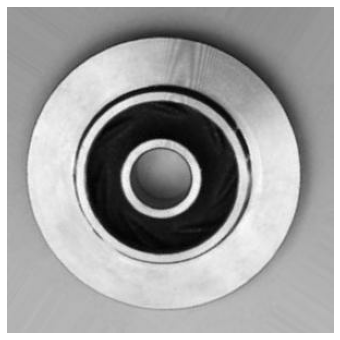

In [66]:
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show();

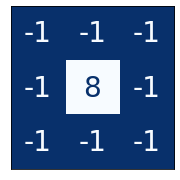

In [67]:
import tensorflow as tf

kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
])

plt.figure(figsize=(3, 3))
show_kernel(kernel)

In [68]:
# Reformat for batch compatibility.
image = tf.image.rgb_to_grayscale(image)
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)

# Prep the kernel
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

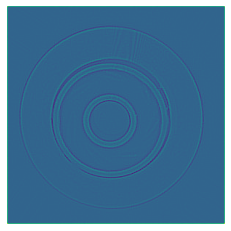

In [69]:
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    # we'll talk about strides and padding in the next session
    strides=1,
    padding='SAME',
)

plt.figure(figsize=(4, 4))
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.show();

And now the ReLU step:

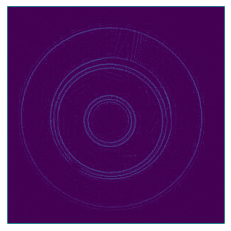

In [70]:
image_detect = tf.nn.relu(image_filter)

plt.figure(figsize=(4, 4))
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.show();

We're going to wrap these steps into a function and simply play around with the kernel to see how it changes the feature mapping for this impellar.

In [72]:
def apply_the_KERN(kernel):
  fig, ax = plt.subplots(1, 3, figsize=(12, 4))

  image_path = technocast_train_path + '/ok_front/cast_ok_0_1.jpeg'
  # image_path = img_path2
  image = tf.io.read_file(image_path)
  image = tf.io.decode_jpeg(image)


  # Reformat for batch compatibility.
  image = tf.image.rgb_to_grayscale(image[:,:,:3])
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.expand_dims(image, axis=0)
  kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
  kernel = tf.cast(kernel, dtype=tf.float32)

  image_filter = tf.nn.conv2d(
      input=image,
      filters=kernel,
      # we'll talk about strides and padding in the next session
      strides=1,
      padding='SAME',
  )

  ax[0].imshow(tf.squeeze(image), cmap='gray')
  ax[0].axis('off')

  ax[1].imshow(tf.squeeze(image_filter))
  ax[1].axis('off')
  image_detect = tf.nn.relu(image_filter)

  ax[2].imshow(tf.squeeze(image_detect))
  ax[2].axis('off')

For this exercise create 2-3 kernels and show how they accentuate different features:

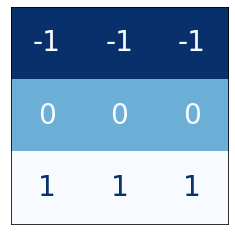

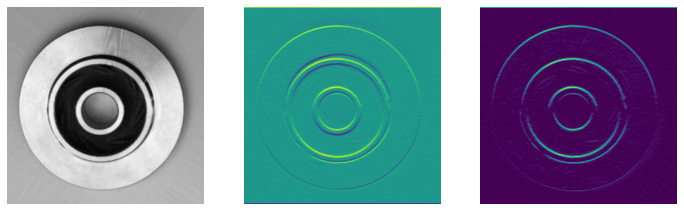

In [77]:
kernel = tf.constant([
  ### YOUR KERNEL HERE ###
  [-1, -1, -1],
  [-1,  8, -1],
  [-1, -1, -1],
])
kernel = tf.constant([
  ### YOUR KERNEL HERE ###
  [-1, 0, 1],
  [-1, 0, 1],
  [-1, 0, 1],
])

kernel = tf.constant([
  ### YOUR KERNEL HERE ###
  [-1, -1, -1],
  [0, 0, 0],
  [1, 1, 1],
])
show_kernel(kernel)

apply_the_KERN(kernel)

> notice anything with different patterns? What happens when the sum of the kernel is more than 0? more than 1?

<a name='x.2.5'></a>

### 3.2.5 Condense with Maximum Pooling

[back to top](#top)

In this last step that we'll cover, we're going to condense the image in a way that accentuates the identified features. This is done with `MaxPool2D` layer in keras



A `MaxPool2D` layer isn't much different from a `Conv2D` layer other than that, instead of taking a sum, the kernel (not really a kernel) just returns the maximum value. `kernel_size` is replaced with `pool_size` and there are no trainable weights (hence not a kernel).

<p align=center>
<img src="https://imgur.com/hK5U2cd.png" width=400></img>

Features are indeed intensified by the max pooling, but another way to think of this is that carrying all those empty "black" pixels through the network is computationally expensive without adding much information. Max pooling is a quick and dirty way of consolidating the network and retaining only the most salient information.

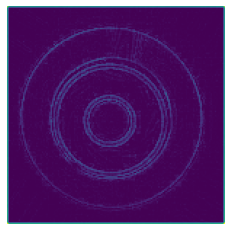

In [78]:
image_condense = tf.nn.pool(
    input=image_detect, # image in the Detect step above
    window_shape=(2, 2),
    pooling_type='MAX',
    # we'll talk about strides and padding in the next session
    strides=(2, 2),
    padding='SAME',
)

plt.figure(figsize=(4, 4))
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.show();

<a name='x.3'></a>

## 3.3 Enrichment: Practice with Global Average Pooling

[back to top](#top)

Usually at the end of the convolutional blocks, we use a `Flatten()` layer to convert the 2D arrays of feature maps to 1D to feed into the Dense layers of the network. Another method that has become popular is to use **_Global Average Pooling_**. With this schematic, each feature map is turned into an average. By this method, the head of the CNN now only has to make a classificaiton based on how _turned on_ the feature maps are, indicated by the result of the global average pooling. We would implement this with keras like so:

```
model = keras.Sequential([
    pretrained_base,
    layers.GlobalAvgPool2D(),
    layers.Dense(1, activation='sigmoid'),
])
```

# Resources

[CNN Explainer](https://poloclub.github.io/cnn-explainer/#article-convolution)